In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster


In [13]:
BASE_URL = "https://data.cdc.gov/resource/r8kw-7aab.json"
LIMIT = 50000
offset = 0
all_data = []

while True:
   params = {
       "$limit": LIMIT,
       "$offset": offset
   }
   response = requests.get(BASE_URL, params=params)
   data = response.json()
   if not data:
       break
   all_data.extend(data)
   offset += LIMIT
   
df = pd.DataFrame(all_data)


In [14]:
print(df.duplicated().sum())
df = df.drop_duplicates()
df.info()

0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18954 entries, 0 to 18953
Data columns (total 17 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   data_as_of                              18954 non-null  object
 1   start_date                              18954 non-null  object
 2   end_date                                18954 non-null  object
 3   group                                   18954 non-null  object
 4   year                                    18900 non-null  object
 5   mmwr_week                               15066 non-null  object
 6   week_ending_date                        15066 non-null  object
 7   state                                   18954 non-null  object
 8   covid_19_deaths                         15092 non-null  object
 9   total_deaths                            18950 non-null  object
 10  percent_of_expected_deaths              18900 non-null  object
 11  

In [15]:
df.isna().sum()

data_as_of                                    0
start_date                                    0
end_date                                      0
group                                         0
year                                         54
mmwr_week                                  3888
week_ending_date                           3888
state                                         0
covid_19_deaths                            3862
total_deaths                                  4
percent_of_expected_deaths                   54
pneumonia_deaths                           1309
pneumonia_and_covid_19_deaths              6593
influenza_deaths                           7740
pneumonia_influenza_or_covid_19_deaths      840
footnote                                   6561
month                                     15444
dtype: int64

In [16]:
df['year'] = df['year'].astype(str).str.extract(r'(\d{4})')
df['state'] = df['state'].replace('New York City', 'New York')

df.year.value_counts()

year
2020    3510
2021    3510
2022    3510
2023    3510
2024    3510
2025    1296
2019      54
Name: count, dtype: int64

In [17]:
# change data types
for col in ['data_as_of', 'start_date', 'end_date', 'week_ending_date']:
   df[col] = pd.to_datetime(df[col])
  
num_col = ['mmwr_week','covid_19_deaths','total_deaths','percent_of_expected_deaths','pneumonia_deaths','pneumonia_and_covid_19_deaths','influenza_deaths','pneumonia_influenza_or_covid_19_deaths','month']
df[num_col] = df[num_col].apply(pd.to_numeric, errors='coerce')

In [18]:
df['group'].value_counts()

group
By Week     15066
By Month     3510
By Year       324
By Total       54
Name: count, dtype: int64

In [19]:
weekly_df = df[df['group'] == 'By Week']
monthly_df = df[df['group'] == 'By Month']
annual_df = df[df['group'] == 'By Year']
total_df = df[df['group'] == 'By Total']

In [20]:
weekly_df.isna().sum()

data_as_of                                    0
start_date                                    0
end_date                                      0
group                                         0
year                                          0
mmwr_week                                     0
week_ending_date                              0
state                                         0
covid_19_deaths                            3642
total_deaths                                  1
percent_of_expected_deaths                    0
pneumonia_deaths                           1282
pneumonia_and_covid_19_deaths              6005
influenza_deaths                           6039
pneumonia_influenza_or_covid_19_deaths      814
footnote                                   4740
month                                     15066
dtype: int64

In [21]:
footnote_value = "One or more data cells have counts between 1-9 and have been suppressed in accordance with NCHS confidentiality standards."

# Loop through each row of the DataFrame
for index, row in weekly_df.iterrows():
    # Check if the footnote column contains the specific value
    if row['footnote'] == footnote_value:
        # If the footnote column has the specific value, fill missing numeric columns with random values between 1 and 9
        for col in weekly_df.select_dtypes(include='number').columns:
            if pd.isna(row[col]):  # Check if the numeric column has a missing value
                weekly_df.at[index, col] = np.random.randint(1, 10)

In [22]:
weekly_df.isna().sum()

data_as_of                                   0
start_date                                   0
end_date                                     0
group                                        0
year                                         0
mmwr_week                                    0
week_ending_date                             0
state                                        0
covid_19_deaths                              0
total_deaths                                 0
percent_of_expected_deaths                   0
pneumonia_deaths                             0
pneumonia_and_covid_19_deaths                0
influenza_deaths                             0
pneumonia_influenza_or_covid_19_deaths       0
footnote                                  4740
month                                     4740
dtype: int64

In [23]:
weekly_df['%_covid'] = (weekly_df['covid_19_deaths'] / weekly_df['total_deaths']) * 100
weekly_df['%_covid+pneumonia'] = (weekly_df['pneumonia_and_covid_19_deaths'] / weekly_df['total_deaths'] )*100
weekly_df['%_covid|pneumonia'] = (weekly_df['pneumonia_influenza_or_covid_19_deaths'] / weekly_df['total_deaths'])*100

/var/folders/59/04rfykkd6m96gklk1909pqyh0000gn/T/ipykernel_55306/1324246747.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekly_df['%_covid'] = (weekly_df['covid_19_deaths'] / weekly_df['total_deaths']) * 100
/var/folders/59/04rfykkd6m96gklk1909pqyh0000gn/T/ipykernel_55306/1324246747.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekly_df['%_covid+pneumonia'] = (weekly_df['pneumonia_and_covid_19_deaths'] / weekly_df['total_deaths'] )*100
/var/folders/59/04rfykkd6m96gklk1909pqyh0000gn/T/ipykerne

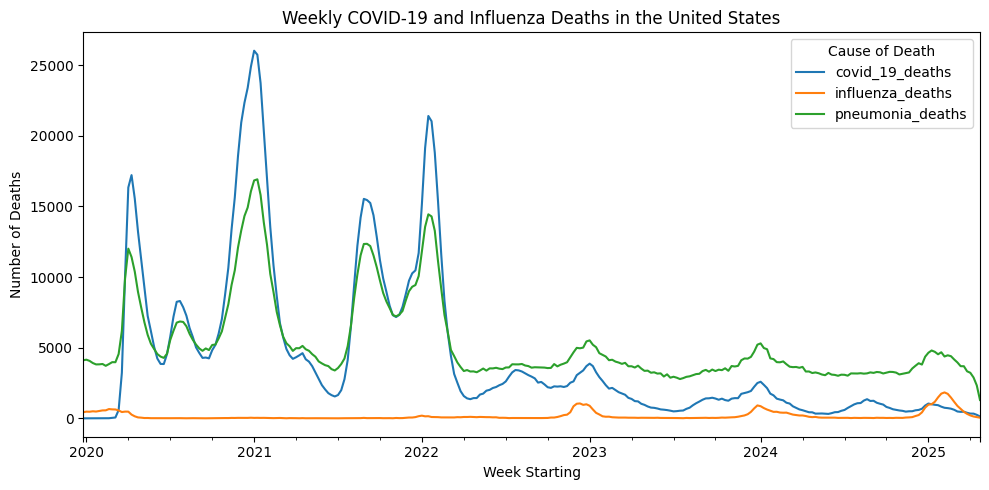

In [24]:
us_df = weekly_df[weekly_df['state'] == 'United States']
us_df.plot(
   kind='line',
   x='start_date',
   y=['covid_19_deaths', 'influenza_deaths','pneumonia_deaths'],
   figsize=(10, 5)
)


plt.xlabel('Week Starting')
plt.ylabel('Number of Deaths')
plt.title('Weekly COVID-19 and Influenza Deaths in the United States')
plt.legend(title='Cause of Death')
plt.tight_layout()
plt.show()


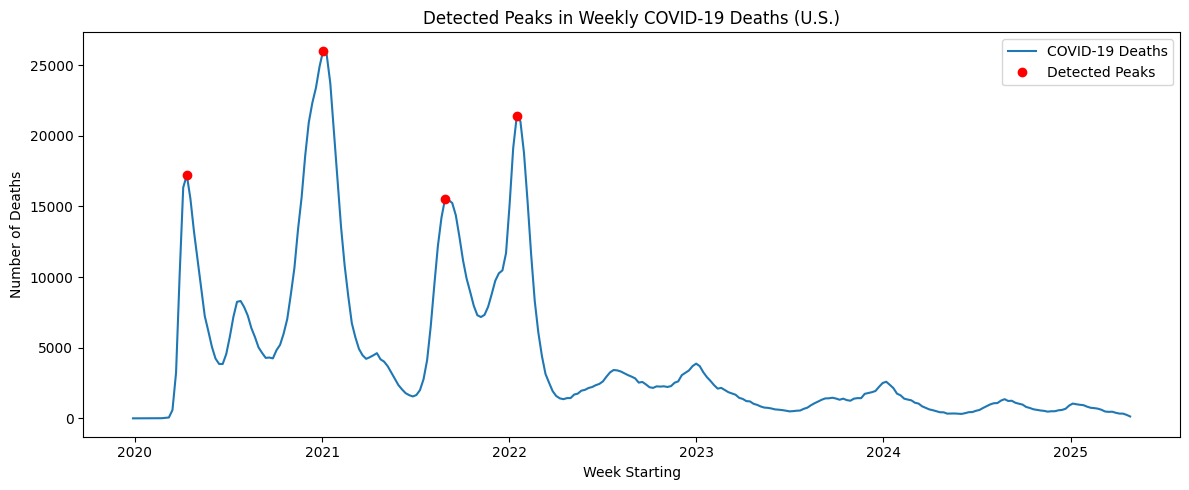

Detected Peak Weeks (COVID-19 Deaths):
start_date
2020-04-12    17221.0
2021-01-03    26028.0
2021-08-29    15539.0
2022-01-16    21407.0
Name: covid_19_deaths, dtype: float64


In [25]:
from scipy.signal import find_peaks
import pandas as pd
import matplotlib.pyplot as plt

# Use the COVID-19 death data
series = us_df.set_index('start_date')['covid_19_deaths']

# Find all peaks
peaks, _ = find_peaks(series, distance=10, prominence=5000)  # tune `distance` and `prominence` as needed

# Get the peak weeks and values
peak_weeks = series.iloc[peaks]

# Plot for visualization
plt.figure(figsize=(12, 5))
plt.plot(series, label='COVID-19 Deaths')
plt.plot(peak_weeks.index, peak_weeks.values, 'ro', label='Detected Peaks')
plt.title('Detected Peaks in Weekly COVID-19 Deaths (U.S.)')
plt.xlabel('Week Starting')
plt.ylabel('Number of Deaths')
plt.legend()
plt.tight_layout()
plt.show()

# Print peak weeks
print("Detected Peak Weeks (COVID-19 Deaths):")
print(peak_weeks.sort_index())


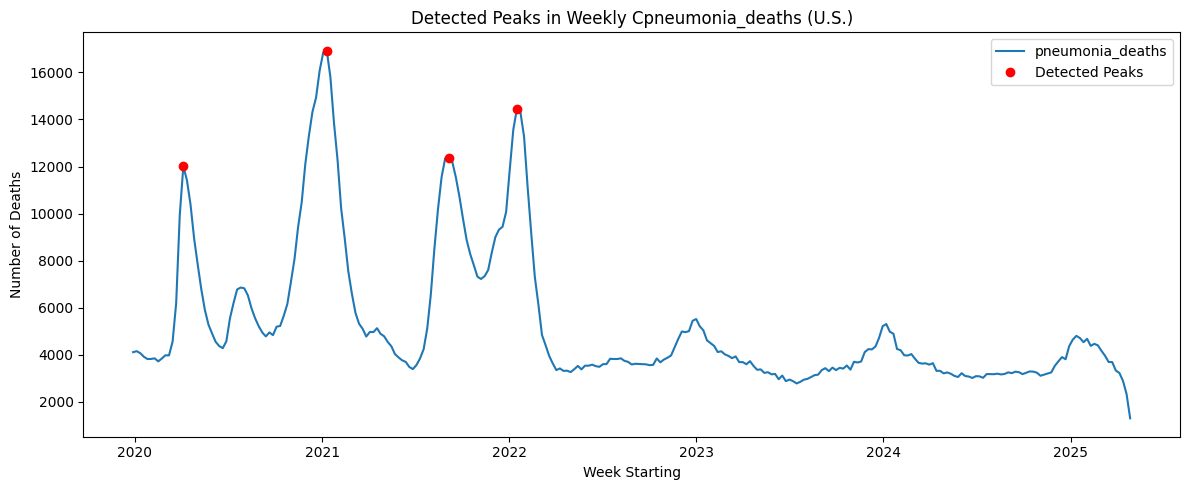

Detected Peak Weeks (pneumonia Deaths):
start_date
2020-04-05    12015.0
2021-01-10    16923.0
2021-09-05    12356.0
2022-01-16    14443.0
Name: pneumonia_deaths, dtype: float64


In [26]:
series = us_df.set_index('start_date')['pneumonia_deaths']

# Find all peaks
peaks, _ = find_peaks(series, distance=10, prominence=5000)  # tune `distance` and `prominence` as needed

# Get the peak weeks and values
peak_weeks = series.iloc[peaks]

# Plot for visualization
plt.figure(figsize=(12, 5))
plt.plot(series, label='pneumonia_deaths')
plt.plot(peak_weeks.index, peak_weeks.values, 'ro', label='Detected Peaks')
plt.title('Detected Peaks in Weekly Cpneumonia_deaths (U.S.)')
plt.xlabel('Week Starting')
plt.ylabel('Number of Deaths')
plt.legend()
plt.tight_layout()
plt.show()

# Print peak weeks
print("Detected Peak Weeks (pneumonia Deaths):")
print(peak_weeks.sort_index())


In [27]:
states_df = weekly_df[weekly_df['state'] != 'United States']
states_covid_weekly = states_df.groupby('state')['covid_19_deaths'].sum()
states_covid_weekly_sorted = states_covid_weekly.sort_values(ascending=False)

In [28]:
top_3_states = states_covid_weekly_sorted.index[:3]
bottom_3_states = states_covid_weekly_sorted.index[-3:]

In [29]:
states_covid_weekly_sorted[top_3_states]

state
California    116362.0
Texas         109098.0
Florida        87420.0
Name: covid_19_deaths, dtype: float64

In [30]:
states_covid_weekly_sorted[bottom_3_states]

state
Wyoming    2347.0
Alaska     1986.0
Vermont    1418.0
Name: covid_19_deaths, dtype: float64

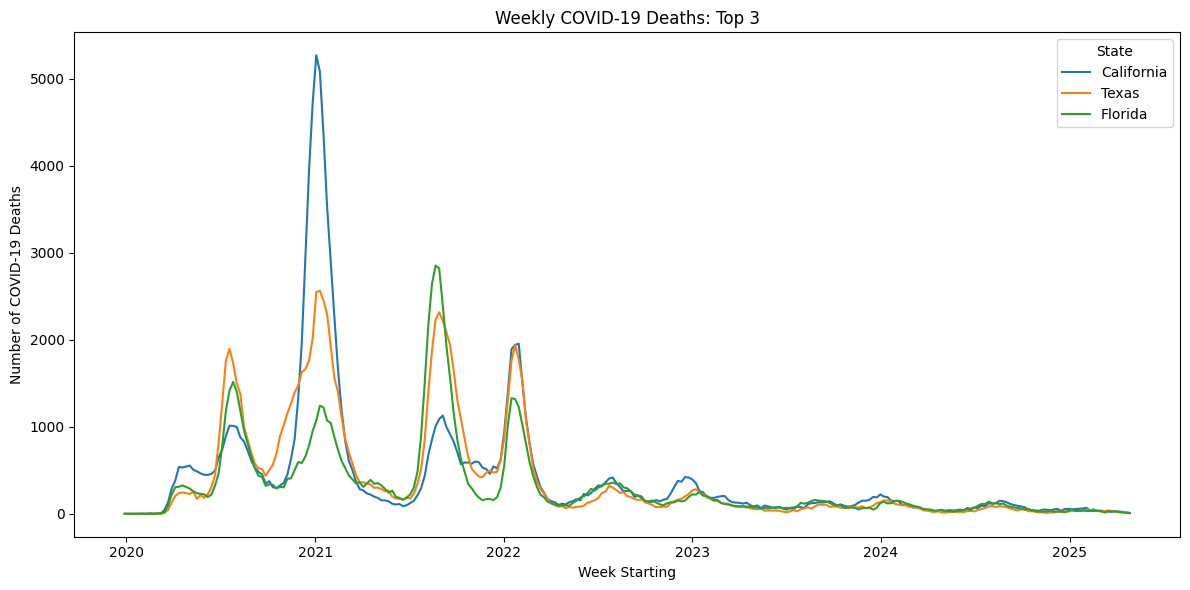

In [31]:
plt.figure(figsize=(12, 6))
for state in top_3_states:
    state_df = weekly_df[weekly_df['state'] == state]
    plt.plot(
        state_df['start_date'],
        state_df['covid_19_deaths'],
        label=state
    )

plt.xlabel('Week Starting')
plt.ylabel('Number of COVID-19 Deaths')
plt.title('Weekly COVID-19 Deaths: Top 3')
plt.legend(title='State')
plt.tight_layout()
plt.show()

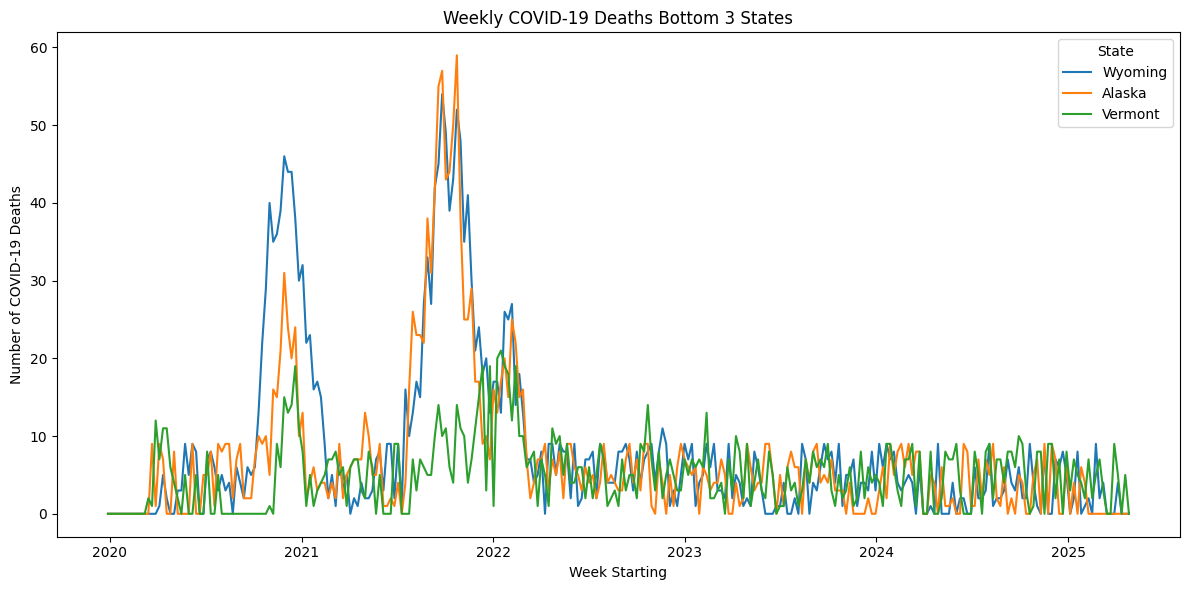

In [32]:
plt.figure(figsize=(12, 6))
for state in bottom_3_states:
    state_df = weekly_df[weekly_df['state'] == state]
    plt.plot(
        state_df['start_date'],
        state_df['covid_19_deaths'],
        label=state
    )

plt.xlabel('Week Starting')
plt.ylabel('Number of COVID-19 Deaths')
plt.title('Weekly COVID-19 Deaths Bottom 3 States')
plt.legend(title='State')
plt.tight_layout()
plt.show()

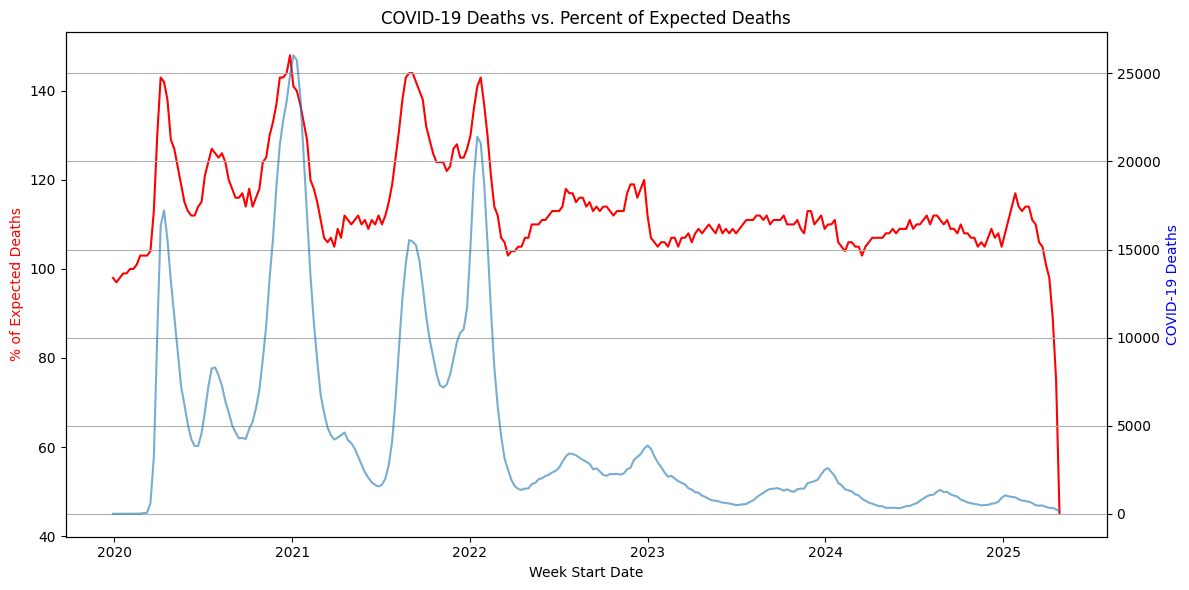

In [33]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Left Y-axis: Percent of Expected Deaths
ax1.plot(us_df['start_date'], us_df['percent_of_expected_deaths'], color='red', label='% of Expected Deaths')
ax1.set_xlabel('Week Start Date')
ax1.set_ylabel('% of Expected Deaths', color='red')
ax1.tick_params(axis='y')

# Right Y-axis: COVID-19 Deaths
ax2 = ax1.twinx()
ax2.plot(us_df['start_date'], us_df['covid_19_deaths'], label='COVID-19 Deaths', alpha=0.6)
ax2.set_ylabel('COVID-19 Deaths', color='blue')
ax2.tick_params(axis='y',)

plt.title('COVID-19 Deaths vs. Percent of Expected Deaths')
fig.tight_layout()
plt.grid(True)
plt.show()


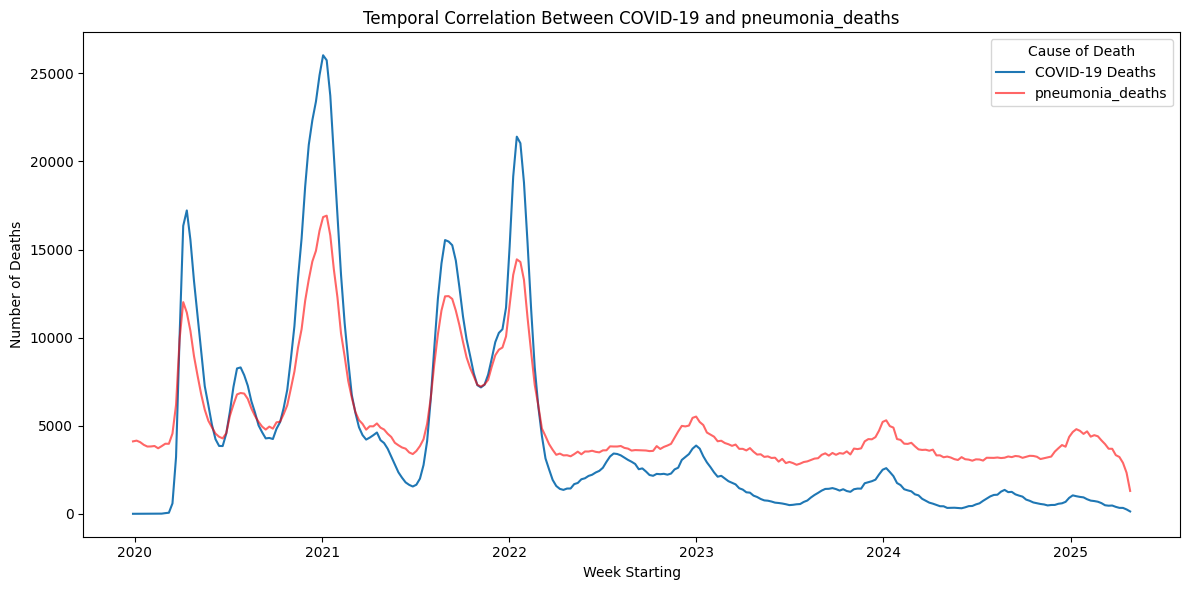

Pearson correlation coefficient between COVID-19 and pneumonia_deaths: 0.982


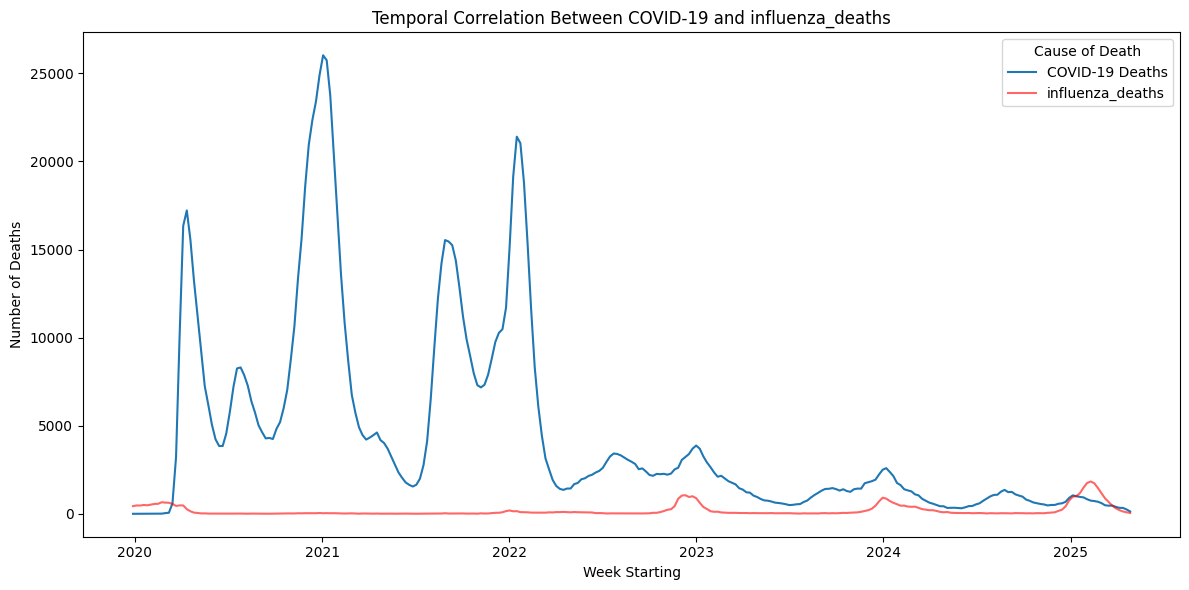

Pearson correlation coefficient between COVID-19 and influenza_deaths: -0.208


In [34]:
for x in ['pneumonia_deaths','influenza_deaths']:
    plt.figure(figsize=(12, 6))
    plt.plot(us_df['start_date'], us_df['covid_19_deaths'], label='COVID-19 Deaths')
    plt.plot(us_df['start_date'], us_df[x], label=x , color='red', alpha=0.6)
    plt.xlabel('Week Starting')
    plt.ylabel('Number of Deaths')
    plt.title(f'Temporal Correlation Between COVID-19 and {x}')
    plt.legend(title='Cause of Death')
    plt.tight_layout()
    plt.show()

    # Calculate Pearson correlation coefficient
    correlation = us_df['covid_19_deaths'].corr(us_df[x])
    print(f'Pearson correlation coefficient between COVID-19 and {x}: {correlation:.3f}')

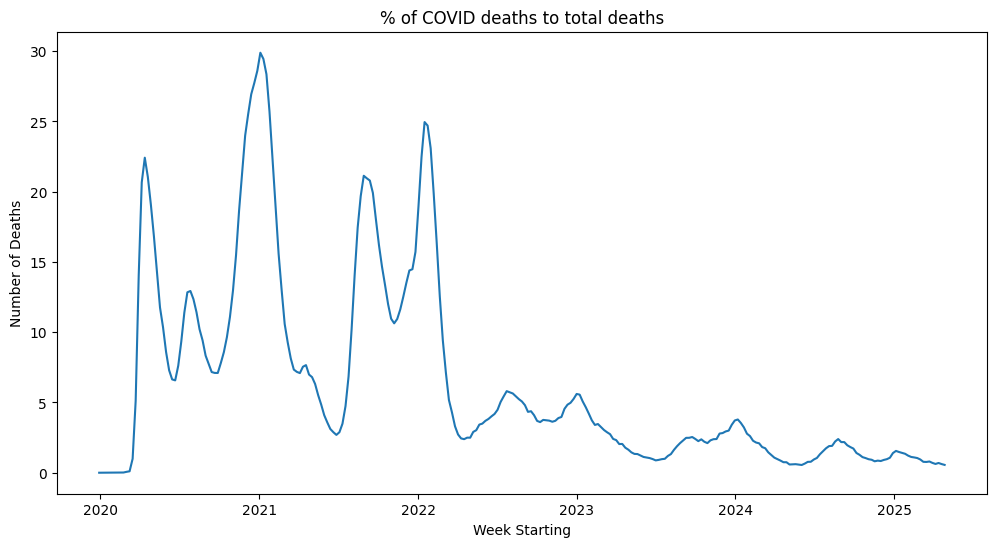

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(us_df['start_date'], us_df['%_covid'])  # directly use plt.plot
plt.xlabel('Week Starting')
plt.ylabel('Number of Deaths')
plt.title('% of COVID deaths to total deaths')
plt.show()

### combined population dataset and check % of covid death by state's population

In [36]:
population = pd.read_csv('State_Population_2019-2025.csv')

In [37]:
# Rename the column 'Unnamed: 0' to 'State'
population.rename(columns={'Unnamed: 0': 'State'}, inplace=True)

pop_long = population.melt(id_vars='State', 
                           var_name='year', 
                           value_name='population')

pop_long['year'] = pop_long['year'].astype(int)
states_df['year'] = states_df['year'].astype(int)

merged_df = states_df.merge(pop_long, 
                            left_on=['state', 'year'], 
                            right_on=['State', 'year'], 
                            how='left')

merged_df.drop(columns='State', inplace=True)


/var/folders/59/04rfykkd6m96gklk1909pqyh0000gn/T/ipykernel_55306/1622344769.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_df['year'] = states_df['year'].astype(int)


In [38]:
merged_df['%_covid_per_pop'] = (merged_df['covid_19_deaths'] / merged_df['population']) * 100

### highest % of covid deaths 

In [39]:
merged_df.groupby('state',)['%_covid_per_pop'].mean().sort_values(ascending=False).head()

state
Mississippi      0.001953
West Virginia    0.001815
Oklahoma         0.001794
Kentucky         0.001792
Tennessee        0.001678
Name: %_covid_per_pop, dtype: float64

### Clustering analysis

In [40]:
# Pivot: rows = states, columns = weeks, values = weekly COVID-19 deaths
aggregated_df = merged_df.groupby(['state', 'week_ending_date'], as_index=False)['covid_19_deaths'].sum()

# Pivot: rows = states, columns = weeks, values = weekly COVID-19 deaths
covid_matrix = aggregated_df.pivot(
    index='state',
    columns='week_ending_date',
    values='covid_19_deaths'
).fillna(0)

In [41]:
scaler = StandardScaler()
covid_scaled = scaler.fit_transform(covid_matrix)

# Preserve state names
covid_scaled_df = pd.DataFrame(covid_scaled, index=covid_matrix.index, columns=covid_matrix.columns)


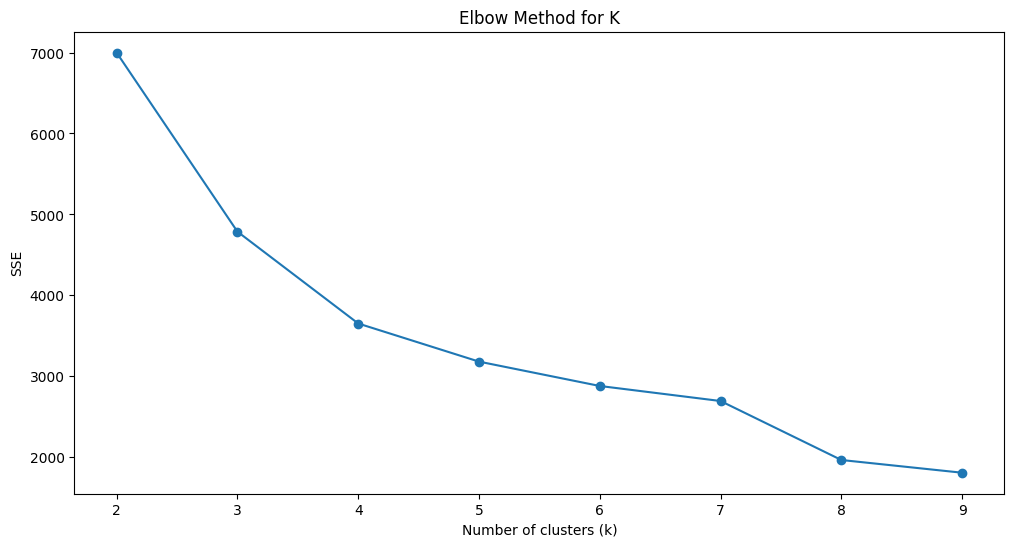

In [42]:
sse = [] 
k_range = range(2, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(covid_scaled)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(12, 6))
plt.plot(k_range, sse, 'o-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('SSE')
plt.title('Elbow Method for K')
plt.show()


In [43]:
# Set the number of clusters based on elbow curve
k = 4

kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(covid_scaled)
covid_matrix['cluster'] = clusters

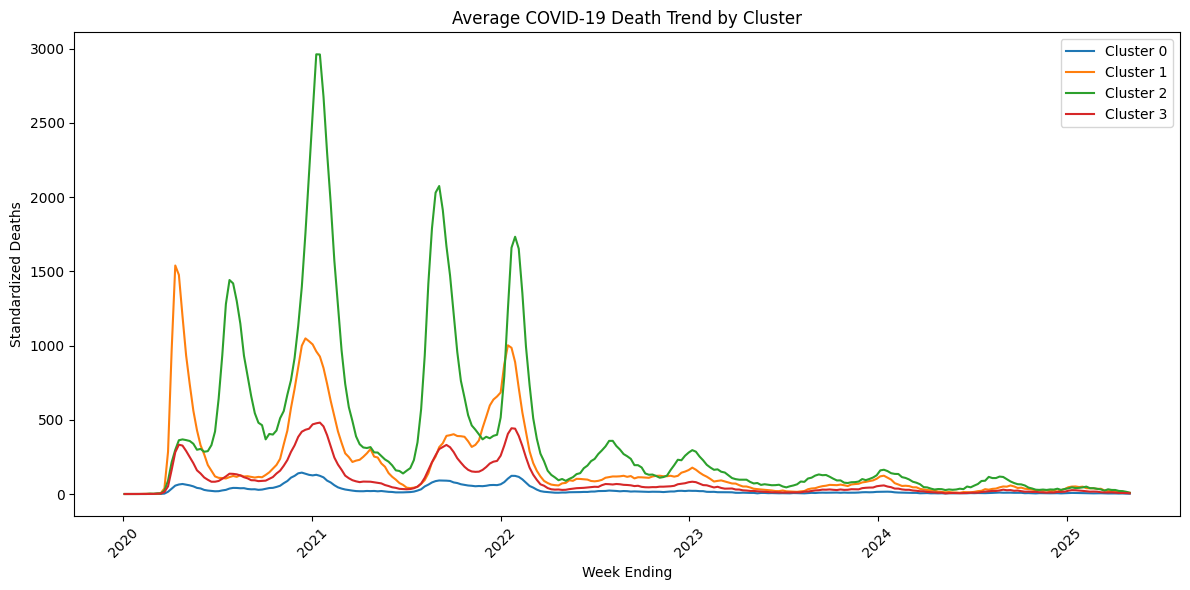

In [44]:
# Plot average trend per cluster
plt.figure(figsize=(12, 6))
for c in sorted(covid_matrix['cluster'].unique()):
    cluster_states = covid_matrix[covid_matrix['cluster'] == c].drop('cluster', axis=1)
    mean_trend = cluster_states.mean()
    plt.plot(mean_trend.index, mean_trend.values, label=f'Cluster {c}')

plt.title('Average COVID-19 Death Trend by Cluster')
plt.xlabel('Week Ending')
plt.ylabel('Standardized Deaths')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [45]:
# Print the states in each cluster
for c in sorted(covid_matrix['cluster'].unique()):
    states_in_cluster = covid_matrix[covid_matrix['cluster'] == c].index.tolist()
    print(f"\nCluster {c} has {len(states_in_cluster)} states:")
    print(states_in_cluster)


Cluster 0 has 26 states:
['Alaska', 'Arkansas', 'Connecticut', 'Delaware', 'District of Columbia', 'Hawaii', 'Idaho', 'Iowa', 'Kansas', 'Louisiana', 'Maine', 'Mississippi', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Mexico', 'North Dakota', 'Oregon', 'Puerto Rico', 'Rhode Island', 'South Dakota', 'Utah', 'Vermont', 'West Virginia', 'Wyoming']

Cluster 1 has 6 states:
['Illinois', 'Michigan', 'New York', 'North Carolina', 'Ohio', 'Pennsylvania']

Cluster 2 has 3 states:
['California', 'Florida', 'Texas']

Cluster 3 has 17 states:
['Alabama', 'Arizona', 'Colorado', 'Georgia', 'Indiana', 'Kentucky', 'Maryland', 'Massachusetts', 'Minnesota', 'Missouri', 'New Jersey', 'Oklahoma', 'South Carolina', 'Tennessee', 'Virginia', 'Washington', 'Wisconsin']


In [46]:
# Group by cluster and calculate the average COVID deaths across all states in each cluster
avg_covid_deaths = covid_matrix.groupby('cluster').mean().mean(axis=1)  
print("Average COVID deaths per cluster:")
print(avg_covid_deaths)


Average COVID deaths per cluster:
cluster
0     26.288944
1    188.085424
2    373.811231
3     88.660974
dtype: float64


In [47]:
# Find the peak week for each state (maximum COVID death week)
peak_weeks = covid_matrix.drop(columns=['cluster']).idxmax(axis=1)  # find the week with the max death count for each state

# Add the peak week information to the original dataframe
covid_matrix['peak_week'] = peak_weeks

# Now group by cluster and find the earliest and latest peak week for each cluster
peak_week_per_cluster = covid_matrix.groupby('cluster')['peak_week'].agg(['min', 'max'])
print("Earliest and Latest peak weeks per cluster:")
print(peak_week_per_cluster)


Earliest and Latest peak weeks per cluster:
               min        max
cluster                      
0       2020-04-18 2022-01-22
1       2020-04-11 2021-01-16
2       2021-01-09 2021-08-28
3       2020-04-18 2022-01-15


In [48]:
footnote_value = "One or more data cells have counts between 1-9 and have been suppressed in accordance with NCHS confidentiality standards."

# Loop through each row of the DataFrame
for index, row in annual_df.iterrows():
    # Check if the footnote column contains the specific value
    if row['footnote'] == footnote_value:
        # If the footnote column has the specific value, fill missing numeric columns with random values between 1 and 9
        for col in annual_df.select_dtypes(include='number').columns:
            if pd.isna(row[col]):  # Check if the numeric column has a missing value
                annual_df.at[index, col] = np.random.randint(1, 10)

In [49]:
annual_df.isna().sum()

data_as_of                                  0
start_date                                  0
end_date                                    0
group                                       0
year                                        0
mmwr_week                                 297
week_ending_date                          324
state                                       0
covid_19_deaths                             0
total_deaths                                0
percent_of_expected_deaths                  0
pneumonia_deaths                            0
pneumonia_and_covid_19_deaths               0
influenza_deaths                            0
pneumonia_influenza_or_covid_19_deaths      0
footnote                                  297
month                                     297
dtype: int64

In [50]:
annual_df

,data_as_of,start_date,end_date,group,year,mmwr_week,week_ending_date,state,covid_19_deaths,total_deaths,percent_of_expected_deaths,pneumonia_deaths,pneumonia_and_covid_19_deaths,influenza_deaths,pneumonia_influenza_or_covid_19_deaths,footnote,month
18576,2025-05-08,2020-01-01,2020-12-31,By Year,2020,NaN,NaT,United States,385676.0,3390079.0,119.0,352022.0,180092.0,8787.0,565242.0,NaN,NaN
18577,2025-05-08,2021-01-01,2021-12-31,By Year,2021,NaN,NaT,United States,463267.0,3471742.0,122.0,412015.0,259617.0,1092.0,616484.0,NaN,NaN
18578,2025-05-08,2022-01-01,2022-12-31,By Year,2022,NaN,NaT,United States,247049.0,3289563.0,116.0,267783.0,110433.0,8783.0,411895.0,NaN,NaN
18579,2025-05-08,2023-01-01,2023-12-31,By Year,2023,NaN,NaT,United States,76042.0,3100910.0,109.0,190816.0,28236.0,6133.0,244285.0,NaN,NaN
18580,2025-05-08,2024-01-01,2024-12-31,By Year,2024,NaN,NaT,United States,47502.0,3081056.0,108.0,183884.0,18770.0,9686.0,221761.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18895,2025-05-08,2021-01-01,2021-12-31,By Year,2021,NaN,NaT,Puerto Rico,1645.0,33264.0,111.0,4443.0,1263.0,55.0,4873.0,NaN,NaN
18896,2025-05-08,2022-01-01,2022-12-31,By Year,2022,NaN,NaT,Puerto Rico,2367.0,35417.0,118.0,5195.0,1566.0,91.0,6067.0,NaN,NaN
18897,2025-05-08,2023-01-01,2023-12-31,By Year,2023,NaN,NaT,Puerto Rico,947.0,34290.0,114.0,4703.0,601.0,136.0,5173.0,NaN,NaN
18898,2025-05-08,2024-01-01,2024-12-31,By Year,2024,NaN,NaT,Puerto Rico,615.0,33098.0,110.0,4574.0,415.0,140.0,4900.0,NaN,NaN


In [51]:
population.State.unique()

array(['United States', 'Alabama', 'Alaska', 'Arizona', 'Arkansas',
       'California', 'Colorado', 'Connecticut', 'Delaware',
       'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
       'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming', 'Puerto Rico'],
      dtype=object)

In [52]:
# Ensure the year column in both dataframes is of the same type
pop_long['year'] = pop_long['year'].astype(int)
annual_df['year'] = annual_df['year'].astype(int)

# Merge the datasets on 'state' and 'year'
combined_df = annual_df.merge(pop_long, 
                              left_on=['state', 'year'], 
                              right_on=['State', 'year'], 
                              how='left')

# Drop the redundant 'State' column from the merged dataframe
combined_df.drop(columns='State', inplace=True)

# Display the combined dataframe
combined_df.head()

/var/folders/59/04rfykkd6m96gklk1909pqyh0000gn/T/ipykernel_55306/3496818596.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annual_df['year'] = annual_df['year'].astype(int)


,data_as_of,start_date,end_date,group,year,mmwr_week,week_ending_date,state,covid_19_deaths,total_deaths,percent_of_expected_deaths,pneumonia_deaths,pneumonia_and_covid_19_deaths,influenza_deaths,pneumonia_influenza_or_covid_19_deaths,footnote,month,population
0,2025-05-08,2020-01-01,2020-12-31,By Year,2020,NaN,NaT,United States,385676.0,3390079.0,119.0,352022.0,180092.0,8787.0,565242.0,NaN,NaN,331449281
1,2025-05-08,2021-01-01,2021-12-31,By Year,2021,NaN,NaT,United States,463267.0,3471742.0,122.0,412015.0,259617.0,1092.0,616484.0,NaN,NaN,331893745
2,2025-05-08,2022-01-01,2022-12-31,By Year,2022,NaN,NaT,United States,247049.0,3289563.0,116.0,267783.0,110433.0,8783.0,411895.0,NaN,NaN,333287557
3,2025-05-08,2023-01-01,2023-12-31,By Year,2023,NaN,NaT,United States,76042.0,3100910.0,109.0,190816.0,28236.0,6133.0,244285.0,NaN,NaN,334914895
4,2025-05-08,2024-01-01,2024-12-31,By Year,2024,NaN,NaT,United States,47502.0,3081056.0,108.0,183884.0,18770.0,9686.0,221761.0,NaN,NaN,336997624


In [53]:
combined_df.columns

Index(['data_as_of', 'start_date', 'end_date', 'group', 'year', 'mmwr_week',
       'week_ending_date', 'state', 'covid_19_deaths', 'total_deaths',
       'percent_of_expected_deaths', 'pneumonia_deaths',
       'pneumonia_and_covid_19_deaths', 'influenza_deaths',
       'pneumonia_influenza_or_covid_19_deaths', 'footnote', 'month',
       'population'],
      dtype='object')

In [54]:
combined_df['%_covid_per_pop'] = (combined_df['covid_19_deaths'] / combined_df['population']) *100

In [55]:
combined_df.groupby(['state','year'])['%_covid_per_pop'].mean().sort_values(ascending=False)

state                 year
West Virginia         2021    0.220869
Mississippi           2021    0.200228
Oklahoma              2021    0.196908
Tennessee             2021    0.196481
New Jersey            2020    0.195554
                                ...   
Washington            2025    0.001624
District of Columbia  2025    0.001343
Utah                  2025    0.001130
Hawaii                2025    0.000819
Alaska                2025    0.000543
Name: %_covid_per_pop, Length: 318, dtype: float64

In [56]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14787 entries, 0 to 14786
Data columns (total 22 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   data_as_of                              14787 non-null  datetime64[ns]
 1   start_date                              14787 non-null  datetime64[ns]
 2   end_date                                14787 non-null  datetime64[ns]
 3   group                                   14787 non-null  object        
 4   year                                    14787 non-null  int64         
 5   mmwr_week                               14787 non-null  float64       
 6   week_ending_date                        14787 non-null  datetime64[ns]
 7   state                                   14787 non-null  object        
 8   covid_19_deaths                         14787 non-null  float64       
 9   total_deaths                            14787 non-

In [57]:
merged_df.to_excel('weekly_df.xlsx')

In [58]:
merged_df[merged_df.start_date== merged_df.start_date.max()]['influenza_deaths'].sum()

149.0